In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
X_train = pd.read_csv("./Datasets/X_train.csv", index_col=[0], header=[0, 1, 2])
y_train = pd.read_csv("./Datasets/Y_train.csv", index_col=[0], header=[0])
X_valid = pd.read_csv("./Datasets/X_valid.csv", index_col=[0], header=[0, 1, 2])
y_valid = pd.read_csv("./Datasets/Y_valid.csv", index_col=[0], header=[0])
X_test = pd.read_csv("./Datasets/X_test.csv", index_col=[0], header=[0, 1, 2])

In [15]:
# Determine the class weight
pos_count = len(y_train[y_train["mort_icu"] == 1])
neg_count = len(y_train[y_train["mort_icu"] == 0])
scale_pos_weight = neg_count / pos_count
scale_pos_weight

12.681632653061225

In [ ]:
# Phase 1: L2-regularization

# Round 1 Cross Validation(CV)
# param_grid = {
#     "max_depth": [3,4,5],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "gamma": [0.1,0.25,1],
#     "reg_lambda": [0,10,50],
#     "scale_pos_weight": [11,12,13,14]
# }
# Best params: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 50, 'scale_pos_weight': 11}

# Round 2 CV
# param_grid = {
#     "max_depth": [4],
#     "learning_rate": [0.1,0.2,0.5],
#     "gamma": [1,2,10],
#     "reg_lambda": [50,70,100],
#     "scale_pos_weight": [8,9,10,11]
# }
# Best params: {'gamma': 1, 'learning_rate': 0.2, 'max_depth': 4, 'reg_lambda': 50, 'scale_pos_weight': 9}

# Phase 2: l1-regularization

# Round 1 CV
# param_grid = {
#     "max_depth": [3,4,5],
#     "learning_rate": [0.1,0.2,1],
#     "gamma": [0.1,0.2,1],
#     "alpha": [50,70,100],
#     "scale_pos_weight": [11,12,13]
# }
# Best params: {'alpha': 50, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'scale_pos_weight': 11}

# Round 2 CV
# param_grid = {
#     "max_depth": [5,6,7],
#     "learning_rate": [0.2,0.4,0.6],
#     "gamma": [0.2,0.4,0.6],
#     "alpha": [50],
#     "scale_pos_weight": [9,10,11]
# }
# Best params: {'alpha': 50, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'scale_pos_weight': 9}

# Round 3 CV
# param_grid = {
#     "max_depth": [7,8],
#     "learning_rate": [0.2,0.3],
#     "gamma": [0.2,0.3],
#     "alpha": [50],
#     "scale_pos_weight": [8,9]
# }
# Best params: {'alpha': 50, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 7, 'scale_pos_weight': 8}

opt_params = GridSearchCV(
    estimator=xgb.XGBRegressor(objective="reg:squarederror", tree_method="gpu_hist", eval_metric="rmse", use_label_encoder=False, seed=42,subsample=0.9,colsample_bytree=0.5),
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    verbose=0,
    n_jobs=10,
    cv=5
)
opt_params.fit(X_train, y_train)

In [ ]:
print(opt_params.best_score_)
print(opt_params.best_params_)

In [17]:
# Classification
clf = xgb.XGBClassifier(objective="binary:logistic",
                        tree_method="gpu_hist", 
                        eval_metric="auc", 
                        use_label_encoder=False, 
                        gamma=0.2, 
                        learning_rate=0.3, 
                        max_depth=7,
                        alpha=50,
                        scale_pos_weight=9, 
                        seed=42)
clf.fit(X_train, y_train, verbose=0, eval_set=[(X_valid, y_valid)])

XGBClassifier(alpha=50, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.2, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=50, reg_lambda=1, scale_pos_weight=9, seed=42,
              subsample=1, tree_method='gpu_hist', use_label_encoder=False, ...)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2187
           1       0.57      0.42      0.48       207

    accuracy                           0.92      2394
   macro avg       0.76      0.69      0.72      2394
weighted avg       0.91      0.92      0.92      2394



<AxesSubplot:>

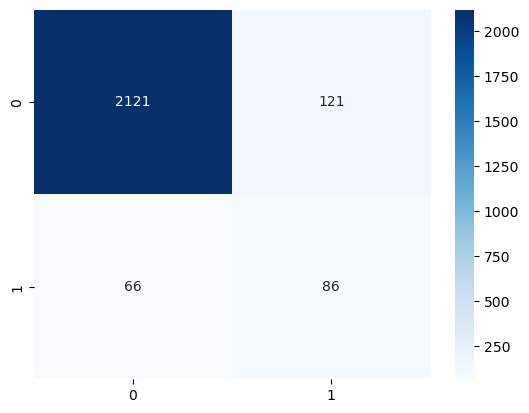

In [25]:
y_pred = clf.predict(X_valid)
print(classification_report(y_pred, y_valid))
sns.heatmap(confusion_matrix(y_valid, y_pred), cmap="Blues", annot=True, fmt="d")

# Final model

In [28]:
X_final = pd.concat([X_train, X_valid])
y_final = pd.concat([y_train, y_valid])

In [33]:
# Finalized model
clf = xgb.XGBClassifier(objective="binary:logistic",
                        tree_method="gpu_hist", 
                        eval_metric="auc", 
                        use_label_encoder=False, 
                        gamma=1, 
                        learning_rate=0.2, 
                        max_depth=4,
                        reg_lambda=50,
                        scale_pos_weight=11, 
                        seed=42)
clf.fit(X_final, y_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=1, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=50, scale_pos_weight=11, seed=42,
              subsample=1, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, ...)

In [34]:
y_prob = clf.predict_proba(X_test)
y_prob_pred = list()

for prob in y_prob:
    y_prob_pred.append(prob[1])

y_out = pd.DataFrame(data=X_test.index,columns=["Id"])
y_out["Predicted"]=y_prob_pred
y_out.head()

,Id,Predicted
0,32_175413_295037,0.129866
1,33_176176_296681,0.018472
2,42_119203_210828,0.021393
3,44_181750_291554,0.003586
4,61_176332_252348,0.038856


In [46]:
y_out.to_csv("Best L2 result.csv", index=False)